In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    log_loss
)

In [3]:
from scipy.stats import uniform, randint
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier

In [4]:
# Load the dataset
df = pd.read_csv("processed_file.csv")

In [5]:
# Display the first few rows
print("DataFrame Head:")
print(df.head())

DataFrame Head:
     amt  is_fraud  age   distance  amt_per_capita  is_far  \
0  54.60         0   44  54.958557        0.540594       0   
1  13.59         0   44  97.146734        0.134554       0   
2  79.04         0   44  23.143879        0.782574       0   
3   3.92         0   44  14.213737        0.038812       0   
4   3.07         0   44  60.874309        0.030396       0   

   hour_bucket_encoded  category_grocery_pos  category_home  \
0                  0.0                   1.0            0.0   
1                  0.0                   0.0            0.0   
2                  0.0                   0.0            1.0   
3                  0.0                   0.0            0.0   
4                  0.0                   0.0            0.0   

   category_shopping_pos  ...  category_entertainment  category_food_dining  \
0                    0.0  ...                     0.0                   0.0   
1                    1.0  ...                     0.0                   0.

In [6]:
# Get the shape of the DataFrame
print("\nDataFrame Shape:")
print(df.shape)



DataFrame Shape:
(1296675, 22)


In [7]:
# Check the class distribution of the target variable
print("\nClass Distribution (is_fraud):")
print(df['is_fraud'].value_counts(normalize=True) * 100)


Class Distribution (is_fraud):
is_fraud
0    99.421135
1     0.578865
Name: proportion, dtype: float64


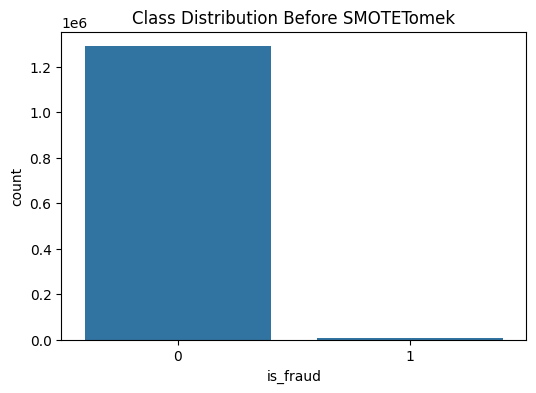

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=df)
plt.title("Class Distribution Before SMOTETomek")
plt.show()

In [9]:
# Separate features (X) and target (y)
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [11]:
# Apply SMOTETomek to the training data to handle imbalance
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)


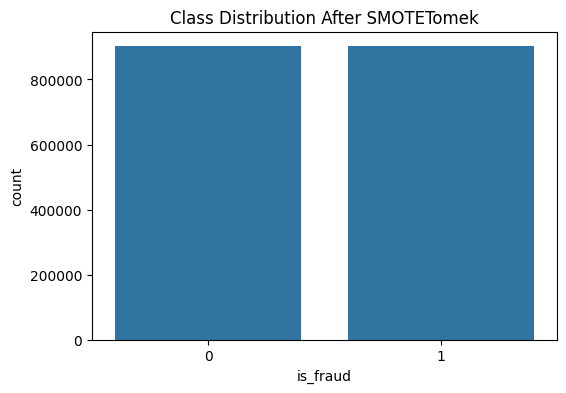

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTETomek")
plt.show()

In [18]:
# Define the parameter distributions for Random Forest's Randomized Search
param_dist = {
    'n_estimators': randint(50,200),      # Number of trees in the forest
    'max_depth': randint(3, 10),             # Maximum tree depth
    'min_samples_split': randint(2, 20),     # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 10),      # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],              # Whether bootstrap samples are used when building trees
    'criterion': ['gini', 'entropy']         # Function to measure the quality of a split
}

In [19]:
# Create a base Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_jobs=4)


In [20]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist,
                                   n_iter=10, cv=3, n_jobs=4, verbose=2, scoring='f1', random_state=42)


In [22]:
# Fit the model on the resampled training data and measure the time
print("\nStarting Randomized Search...")
start_time = time.time()
random_search.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
time_taken = end_time - start_time
print(f"Randomized Search completed in {time_taken:.2f} seconds.")



Starting Randomized Search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Randomized Search completed in 2270.59 seconds.


In [23]:
# Print the best parameters found
print("\nBest Parameters found by RandomizedSearchCV:")
print(random_search.best_params_)



Best Parameters found by RandomizedSearchCV:
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 137}


In [24]:
# Make predictions on the test set using the best model from the search
y_pred = random_search.predict(X_test)
y_pred_proba = random_search.predict_proba(X_test)[:, 1]

In [25]:
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    386751
           1       0.23      0.84      0.36      2252

    accuracy                           0.98    389003
   macro avg       0.61      0.91      0.67    389003
weighted avg       0.99      0.98      0.99    389003



In [26]:
# Calculate and print additional metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)
logloss = log_loss(y_test, y_pred_proba)

In [27]:
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"Log Loss: {logloss:.4f}")

Accuracy: 0.9825
AUC Score: 0.9801
Log Loss: 0.1540


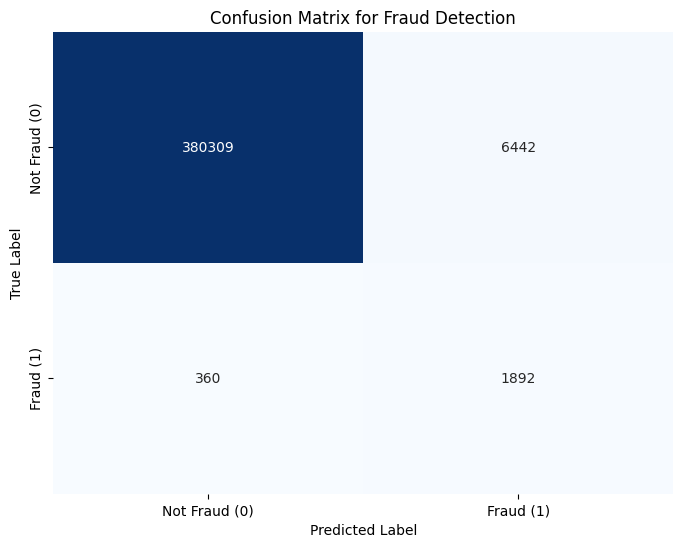

In [28]:
# Create and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud (0)', 'Fraud (1)'],
            yticklabels=['Not Fraud (0)', 'Fraud (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Fraud Detection')
plt.show()

In [29]:
# Save the best model
joblib.dump(random_search, 'Best_Fraud_Model_RandomForest.pkl')
print("\nModel saved as Best_Fraud_Model_RandomForest.pkl")


Model saved as Best_Fraud_Model_RandomForest.pkl


In [30]:
# Access the best-performing model from the search
best_rf_model = random_search.best_estimator_

In [31]:
# Get and print the top 10 most important features
importances = best_rf_model.feature_importances_
feature_names = X.columns
feature_importance_series = pd.Series(importances, index=feature_names)
sorted_importance = feature_importance_series.sort_values(ascending=False)
print("\nTop 10 Most Important Features:")
print(sorted_importance.head(10))


Top 10 Most Important Features:
amt                        0.538866
amt_per_capita             0.100529
gender_M                   0.083014
category_grocery_pos       0.064430
city_freq                  0.033736
category_entertainment     0.031907
category_shopping_net      0.025486
category_home              0.023095
category_health_fitness    0.018843
category_misc_pos          0.016116
dtype: float64
